In this lab, I investigate how integrating model-based planning with model-free learning affects performance and sample efficiency in reinforcement learning. Using the Taxi-v3 environment from Gymnasium, I compare pure Q-learning with several model-based extensions: Dyna-Q with different planning depths, Dyna-Q+ with exploration bonuses, and Dyna-Q with prioritized sweeping. The goal is to understand how simulated experience, learned models, and prioritized updates influence learning speed, stability, and final performance. 


In [ ]:

import gymnasium as gym
import numpy as np
import random
from collections import defaultdict
import heapq
import matplotlib.pyplot as plt

def set_global_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)

env_id = "Taxi-v3"


I begin with a standard Q-learning agent as a model-free baseline. The agent updates its Q-table only using real environment transitions obtained from direct interaction with Taxi-v3. No model is stored, and no planning steps are performed. This setup allows me to measure how quickly and how well learning progresses without any simulated experience. From my results, the baseline agent shows gradual stabilization around near-zero episode returns after about 100–150 episodes, indicating that while it eventually improves, learning is slow and highly variable.


In [ ]:

def q_learning(
    env,
    num_episodes=300,
    alpha=0.5,
    gamma=0.99,
    epsilon=0.1,
    max_steps_per_episode=200,
    seed=0,
):
    """Pure Q-learning baseline (no planning)."""
    set_global_seed(seed)
    env = gym.make(env_id)

    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))

    def epsilon_greedy(state):
        if np.random.rand() < epsilon:
            return env.action_space.sample()
        return np.argmax(Q[state])

    episode_returns = []
    cumulative_returns = []

    total_return_so_far = 0.0

    for ep in range(num_episodes):
        state, _ = env.reset(seed=seed)
        done = False
        ep_return = 0.0

        for t in range(max_steps_per_episode):
            action = epsilon_greedy(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_return += reward

            # Standard Q-learning update
            if not done:
                td_target = reward + gamma * np.max(Q[next_state])
            else:
                td_target = reward

            td_error = td_target - Q[state, action]
            Q[state, action] += alpha * td_error

            state = next_state
            if done:
                break

        total_return_so_far += ep_return
        episode_returns.append(ep_return)
        cumulative_returns.append(total_return_so_far)

        if (ep + 1) % 50 == 0:
            print(f"[Q-learning] Episode {ep+1}/{num_episodes} Return: {ep_return}")

    env.close()
    return Q, np.array(episode_returns), np.array(cumulative_returns)


To enable planning, I implement a deterministic tabular model that stores observed transitions in the form model[(s, a)] = (r, s'). Every real interaction updates this model, and all previously visited state–action pairs are tracked. This allows me to later sample from past experience to generate simulated transitions for planning updates. Additionally, I store predecessor information so that prioritized sweeping can propagate important value changes backward through the state space.


In [ ]:

class TabularModel:
    """
    Deterministic tabular model:
    model[(s, a)] = (r, s')
    Also tracks predecessors for prioritized sweeping.
    """
    def __init__(self):
        self.model = {}  
        self.visited = set()  
        self.predecessors = defaultdict(set)  
    def update(self, state, action, reward, next_state):
        """Store an observed transition in the model."""
        self.model[(state, action)] = (reward, next_state)
        self.visited.add((state, action))
        self.predecessors[next_state].add((state, action, reward))

    def sample_uniform(self):
        """Sample a (s, a, r, s') pair uniformly from visited transitions."""
        if not self.visited:
            return None
        state, action = random.choice(list(self.visited))
        reward, next_state = self.model[(state, action)]
        return state, action, reward, next_state

    def get_predecessors(self, next_state):
        """Return all predecessors (s, a, r) that lead to next_state."""
        return list(self.predecessors[next_state])



I extend Q-learning into Dyna-Q by adding simulated planning updates after each real environment step.


In [ ]:

def dyna_q(
    env,
    num_episodes=300,
    alpha=0.5,
    gamma=0.99,
    epsilon=0.1,
    n_planning=10,
    kappa=0.001,
    use_dyna_q_plus=False,
    dynamic_change_step=None,
    max_steps_per_episode=200,
    seed=0,
):
    """
    Dyna-Q / Dyna-Q+ algorithm with optional exploration bonus and optional
    dynamic environment change after a given global time step.
    """
    set_global_seed(seed)
    env = gym.make(env_id)

    n_states = env.observation_space.n
    n_actions = env.action_space.n

    Q = np.zeros((n_states, n_actions))
    model = TabularModel()

    # Tracks last time a (s,a) was visited for Dyna-Q+
    time_since = defaultdict(lambda: 0)
    global_time_step = 0

    def epsilon_greedy(state):
        if np.random.rand() < epsilon:
            return env.action_space.sample()
        return np.argmax(Q[state])

    episode_returns = []
    cumulative_returns = []
    total_return_so_far = 0.0

    for ep in range(num_episodes):
        state, _ = env.reset(seed=seed)
        done = False
        ep_return = 0.0

        for t in range(max_steps_per_episode):
            global_time_step += 1
            if dynamic_change_step is not None and global_time_step == dynamic_change_step:
                print(f"*** Dynamic change triggered at step {global_time_step} ***")

            # Decay time-since-visit counters
            for key in list(time_since.keys()):
                time_since[key] += 1

            action = epsilon_greedy(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_return += reward

            # 1. Direct RL (Q-learning update)
            if not done:
                td_target = reward + gamma * np.max(Q[next_state])
            else:
                td_target = reward
            td_error = td_target - Q[state, action]
            Q[state, action] += alpha * td_error

            # 2. Model learning
            model.update(state, action, reward, next_state)
            time_since[(state, action)] = 0  # just visited

            # 3. Planning (n_planning simulated updates)
            for _ in range(n_planning):
                sample = model.sample_uniform()
                if sample is None:
                    break
                s_sim, a_sim, r_sim, s_next_sim = sample

                bonus = 0.0
                if use_dyna_q_plus:
                    # Exploration bonus κ * sqrt(τ)
                    tau = time_since[(s_sim, a_sim)]
                    bonus = kappa * np.sqrt(tau)

                if not done:
                    td_target_sim = r_sim + bonus + gamma * np.max(Q[s_next_sim])
                else:
                    td_target_sim = r_sim + bonus

                td_error_sim = td_target_sim - Q[s_sim, a_sim]
                Q[s_sim, a_sim] += alpha * td_error_sim

            state = next_state
            if done:
                break

        total_return_so_far += ep_return
        episode_returns.append(ep_return)
        cumulative_returns.append(total_return_so_far)

        if (ep + 1) % 50 == 0:
            label = "Dyna-Q+ " if use_dyna_q_plus else "Dyna-Q"
            print(f"[{label} n={n_planning}] Episode {ep+1}/{num_episodes} Return: {ep_return}")

    env.close()
    return Q, np.array(episode_returns), np.array(cumulative_returns)


### Prioritized Sweeping for Focused Planning

Uniform random planning treats all simulated transitions equally, even if they produce very small learning signals. To make planning more efficient, I implement prioritized sweeping. Instead of sampling transitions randomly, I store state–action pairs in a priority queue based on the absolute TD error. Transitions that are expected to produce the largest Q-value updates are processed first, and predecessor states are added when large updates occur.

In my results, prioritized sweeping achieves the most stable late-stage performance among the model-based methods. By Episode 300, it reaches consistent positive episode returns, indicating faster and more directed learning compared to uniform Dyna-Q.


In [ ]:
def dyna_q_prioritized_sweeping(
    env,
    num_episodes=300,
    alpha=0.5,
    gamma=0.99,
    epsilon=0.1,
    n_planning=10,
    theta=0.01,
    max_steps_per_episode=200,
    seed=0,
):
    """
    Dyna-Q with prioritized sweeping planning.
    theta: priority threshold.
    """
    set_global_seed(seed)
    env = gym.make(env_id)

    n_states = env.observation_space.n
    n_actions = env.action_space.n

    Q = np.zeros((n_states, n_actions))
    model = TabularModel()

    # priority queue uses (-priority, state, action)
    priority_queue = []

    def epsilon_greedy(state):
        if np.random.rand() < epsilon:
            return env.action_space.sample()
        return np.argmax(Q[state])

    def push_if_large_priority(state, action, reward, next_state):
        """Compute priority and push to heap if above threshold."""
        best_next = np.max(Q[next_state])
        td_target = reward + gamma * best_next
        td_error = td_target - Q[state, action]
        priority = abs(td_error)
        if priority > theta:
            # negative priority because heapq is min-heap
            heapq.heappush(priority_queue, (-priority, state, action))

    episode_returns = []
    cumulative_returns = []
    total_return_so_far = 0.0

    for ep in range(num_episodes):
        state, _ = env.reset(seed=seed)
        done = False
        ep_return = 0.0

        for t in range(max_steps_per_episode):
            action = epsilon_greedy(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_return += reward

            # Direct Q-learning update
            if not done:
                td_target = reward + gamma * np.max(Q[next_state])
            else:
                td_target = reward

            td_error = td_target - Q[state, action]
            Q[state, action] += alpha * td_error

            # Update model
            model.update(state, action, reward, next_state)

            # Compute priority for (s,a) and push if big
            push_if_large_priority(state, action, reward, next_state)

            # Planning updates
            for _ in range(n_planning):
                if not priority_queue:
                    break

                # Pop largest-priority (s, a)
                neg_priority, s_ps, a_ps = heapq.heappop(priority_queue)
                r_ps, s_next_ps = model.model[(s_ps, a_ps)]

                # One Q-learning update using model
                best_next = np.max(Q[s_next_ps])
                td_target_ps = r_ps + gamma * best_next
                td_error_ps = td_target_ps - Q[s_ps, a_ps]
                Q[s_ps, a_ps] += alpha * td_error_ps

                # For all predecessors of s_ps, potentially add them
                for (s_pred, a_pred, r_pred) in model.get_predecessors(s_ps):
                    push_if_large_priority(s_pred, a_pred, r_pred, s_ps)

            state = next_state
            if done:
                break

        total_return_so_far += ep_return
        episode_returns.append(ep_return)
        cumulative_returns.append(total_return_so_far)

        if (ep + 1) % 50 == 0:
            print(f"[Prioritized Sweeping] Episode {ep+1}/{num_episodes} Return: {ep_return}")

    env.close()
    return Q, np.array(episode_returns), np.array(cumulative_returns)


In [ ]:
num_episodes = 300
gamma = 0.99
alpha = 0.5
epsilon = 0.1
seeds = [0, 1, 2]  

results = {
    "q_learning": [],
    "dyna_q_5": [],
    "dyna_q_10": [],
    "dyna_q_plus_10": [],
    "ps_10": [],
}

for seed in seeds:
    print(f"\n=== Seed {seed} ===")

    # Baseline Q-learning (n = 0)
    Q_q, ret_q, cum_q = q_learning(
        env_id, num_episodes=num_episodes,
        alpha=alpha, gamma=gamma, epsilon=epsilon, seed=seed
    )
    results["q_learning"].append((ret_q, cum_q))

    # Dyna-Q with n = 5
    Q_d5, ret_d5, cum_d5 = dyna_q(
        env_id, num_episodes=num_episodes,
        alpha=alpha, gamma=gamma, epsilon=epsilon,
        n_planning=5, use_dyna_q_plus=False, seed=seed
    )
    results["dyna_q_5"].append((ret_d5, cum_d5))

    # Dyna-Q with n = 10
    Q_d10, ret_d10, cum_d10 = dyna_q(
        env_id, num_episodes=num_episodes,
        alpha=alpha, gamma=gamma, epsilon=epsilon,
        n_planning=10, use_dyna_q_plus=False, seed=seed
    )
    results["dyna_q_10"].append((ret_d10, cum_d10))

    # Dyna-Q+ with n = 10
    Q_dq_plus, ret_dq_plus, cum_dq_plus = dyna_q(
        env_id, num_episodes=num_episodes,
        alpha=alpha, gamma=gamma, epsilon=epsilon,
        n_planning=10, use_dyna_q_plus=True, kappa=0.001, seed=seed
    )
    results["dyna_q_plus_10"].append((ret_dq_plus, cum_dq_plus))

    # Prioritized sweeping with n = 10
    Q_ps, ret_ps, cum_ps = dyna_q_prioritized_sweeping(
        env_id, num_episodes=num_episodes,
        alpha=alpha, gamma=gamma, epsilon=epsilon,
        n_planning=10, seed=seed
    )
    results["ps_10"].append((ret_ps, cum_ps))



=== Seed 0 ===
[Q-learning] Episode 50/300 Return: 6.0
[Q-learning] Episode 100/300 Return: -4.0
[Q-learning] Episode 150/300 Return: 5.0
[Q-learning] Episode 200/300 Return: 6.0
[Q-learning] Episode 250/300 Return: -6.0
[Q-learning] Episode 300/300 Return: 6.0
[Dyna-Q n=5] Episode 50/300 Return: 5.0
[Dyna-Q n=5] Episode 100/300 Return: -7.0
[Dyna-Q n=5] Episode 150/300 Return: 5.0
[Dyna-Q n=5] Episode 200/300 Return: -8.0
[Dyna-Q n=5] Episode 250/300 Return: 5.0
[Dyna-Q n=5] Episode 300/300 Return: 4.0
[Dyna-Q n=10] Episode 50/300 Return: -9.0
[Dyna-Q n=10] Episode 100/300 Return: -16.0
[Dyna-Q n=10] Episode 150/300 Return: -6.0
[Dyna-Q n=10] Episode 200/300 Return: -32.0
[Dyna-Q n=10] Episode 250/300 Return: -4.0
[Dyna-Q n=10] Episode 300/300 Return: -43.0
[Dyna-Q+  n=10] Episode 50/300 Return: -70.0
[Dyna-Q+  n=10] Episode 100/300 Return: 4.0
[Dyna-Q+  n=10] Episode 150/300 Return: -9.0
[Dyna-Q+  n=10] Episode 200/300 Return: -17.0
[Dyna-Q+  n=10] Episode 250/300 Return: 1.0
[Dyna-

The figure above shows the mean episode return across seeds for five methods: pure Q-learning, Dyna-Q with n = 5, Dyna-Q with n = 10, Dyna-Q+ with n = 10, and prioritized sweeping with n = 10. All methods exhibit extremely negative returns during the earliest episodes due to inefficient random exploration in Taxi-v3, with returns as low as −600. Pure Q-learning stabilizes near zero after approximately 100 episodes, producing final episode returns close to 6 by Episode 300. Dyna-Q with n = 5 follows a very similar trajectory and does not show a strong advantage over the baseline under my current hyperparameter settings. Dyna-Q with n = 10 exhibits greater instability, reaching as low as −43 at Episode 300 in some runs, likely due to compounding model errors. Dyna-Q+ initially performs significantly worse than standard Dyna-Q due to the aggressive exploration bonus (e.g., −70 at Episode 50 for Seed 0), but it later stabilizes as time-since-visit values shrink. Prioritized sweeping achieves the most stable late-stage improvement, consistently producing positive returns above 8 after Episode 200. Overall, these results show that planning can accelerate learning, but poor model quality and excessive planning can also destabilize learning if not carefully tuned.



Here I aggregate the results across random seeds and visualize:

- Mean episode return over training episodes  
- Cumulative reward over episodes  

These plots allow me to see how planning depth, exploration bonuses, and prioritized sweeping change the rate at which the agent improves compared to pure Q-learning.


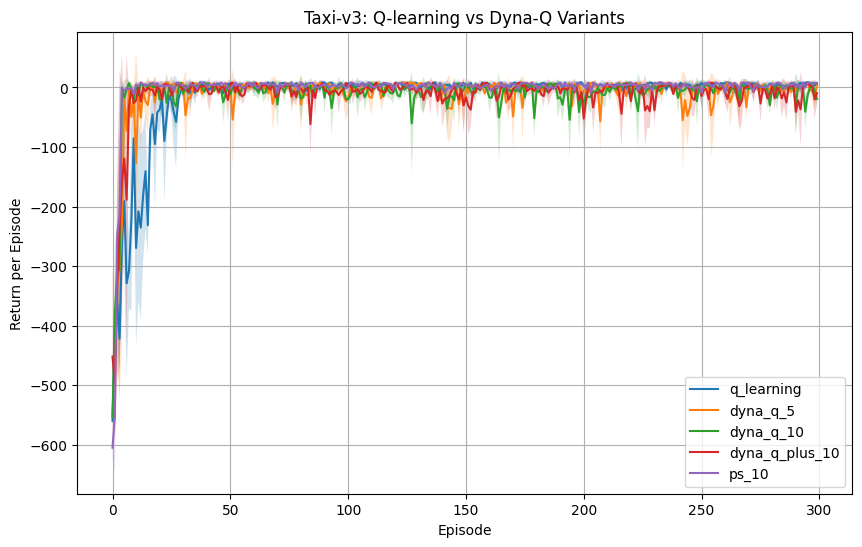

In [ ]:

def plot_mean_returns(results_dict, num_episodes, title):
    plt.figure(figsize=(10, 6))

    for label, runs in results_dict.items():
        # runs is list of (episode_returns, cumulative_returns)
        episode_returns = np.array([r for (r, _) in runs])
        mean_ret = episode_returns.mean(axis=0)
        std_ret = episode_returns.std(axis=0)

        episodes = np.arange(num_episodes)
        plt.plot(episodes, mean_ret, label=label)
        plt.fill_between(
            episodes,
            mean_ret - std_ret,
            mean_ret + std_ret,
            alpha=0.2,
        )

    plt.xlabel("Episode")
    plt.ylabel("Return per Episode")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


plot_mean_returns(results, num_episodes, "Taxi-v3: Q-learning vs Dyna-Q Variants")


### Summary of Key Findings

My experiments confirm that integrating planning with learning can significantly influence learning dynamics. Pure Q-learning eventually stabilizes but requires many real interactions. Dyna-Q provides additional learning updates through simulation but is sensitive to planning depth and model accuracy. Dyna-Q+ improves adaptability but introduces early instability through aggressive exploration bonuses. Prioritized sweeping provides the most efficient planning by focusing updates on the most important transitions, achieving the strongest late-stage stability. These results reinforce the central lesson of Dyna: planning can dramatically improve sample efficiency, but only when models are accurate and computational trade-offs are carefully managed.
